In [1]:
import sys
import tensorflow as tf
import tensorflow_probability as tfp
import numpy
import numpy as np
print(np.__version__)
from matplotlib import pyplot as plt, cm
import matplotlib.pyplot as plt
import time
from scipy.fft import fft, fftfreq




1.26.4


In [19]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, t_u, x_u, layers, kappa, lt, ut, acts=0):

        self.scale = tf.reduce_max(tf.abs(x_u)) / 2
        x_u2 = x_u / self.scale
        actv = [tf.tanh, tf.sin]

        self.t_u = t_u
        self.x_u = x_u2
        self.datatype = t_u.dtype

        self.lt = lt
        self.ut = ut

        self.layers = layers
        self.kappa = kappa

        # determine the activation function to use
        self.actv = actv[acts]

        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be
        #            automatically updated in the original tf.Variable

        # define the loss function
        self.loss0 = self.scale ** 2
        self.loss = []
        self.loss_0 = self.loss_NN()

        self.optimizer_Adam = tf.optimizers.Adam()

    '''
    Functions used to establish the initial neural network
    ===============================================================
    '''

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)

        for l in range(0, num_layers - 1):
            W = self.MPL_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=self.datatype))
            weights.append(W)
            biases.append(b)
        return weights, biases

    def MPL_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.datatype))

    '''
    Functions used to building the physics-informed contrainst and loss
    ===============================================================
    '''

    def neural_net(self, X):
        weights = self.weights
        biases = self.biases

        num_layers = len(weights) + 1
        
        H = 2.0 * tf.math.divide(tf.math.subtract(X, tf.transpose(self.lt)), tf.transpose(tf.math.subtract(self.ut, self.lt))) - 1.0
        
        W = weights[0]
        b = biases[0]
        H = self.actv(tf.add(self.kappa * tf.matmul(H, W), b))

        for l in range(1, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    @tf.function
    # calculate the physics-informed loss function
    def loss_NN(self):
        self.x_pred = self.neural_net(self.t_u)
        loss = tf.reduce_mean(tf.square(self.x_u - self.x_pred))
        return loss

    '''
    Functions used to define ADAM optimizers
    ===============================================================
    '''

    # define the function to apply the ADAM optimizer
    def adam_function(self):
        @tf.function
        def f():
            # calculate the loss
            loss_norm = self.loss_NN()
            loss_value = loss_norm * self.loss0
            # store loss value so we can retrieve later
            tf.py_function(f.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            str_iter = tf.strings.as_string([f.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: Adam", ", Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f.iter % 100 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )
            return loss_norm

        f.iter = tf.Variable(0)
        f.term = []
        f.loss = []
        return f

    def Adam_optimizer(self, nIter):
        varlist = self.train_variables
        func_adam = self.adam_function()
        for it in range(nIter):
            tf.keras.optimizers.Adam(func_adam, varlist)
            #self.optimizer_Adam.minimize(func_adam, varlist)
        return func_adam

    '''
    Functions used to define L-BFGS optimizers
    ===============================================================
    '''

    # A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    def Lbfgs_function(self, varlist):
        # obtain the shapes of all trainable parameters in the model
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)

        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = []  # stitch indices
        part = []  # partition indices

        self.start_time = time.time()

        for i, shape in enumerate(shapes):
            n = np.prod(shape)
            idx.append(tf.reshape(tf.range(count, count + n, dtype=tf.int32), shape))
            part.extend([i] * n)
            count += n

        part = tf.constant(part)

        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self

            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                varlist[i].assign(tf.reshape(param, shape))

        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self

            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_norm = self.loss_NN()
                loss_value = loss_norm * self.loss0

            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_norm, varlist)
            grads = tf.dynamic_stitch(idx, grads)

            # store loss value so we can retrieve later
            tf.py_function(f.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            str_iter = tf.strings.as_string([f.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: LBFGS", ", Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f.iter % 3000 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )

            return loss_value, grads

        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.loss = []

        return f

    # define the function to apply the L-BFGS optimizer
    def Lbfgs_optimizer(self, nIter, varlist):

        func = self.Lbfgs_function(varlist)

        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, varlist)

        max_nIter = tf.cast(nIter / 3, dtype=tf.int32)

        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params,
            tolerance=1e-11, max_iterations=max_nIter)

        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)

        return func

    '''
    Function used for training the model
    ===============================================================
    '''

    def train(self, nIter, idxOpt):
        if idxOpt == 1:
            # mode 1: running the Adam optimization
            func_adam = self.Adam_optimizer(nIter)
            self.loss += func_adam.loss
        elif idxOpt == 2:
            # mode 2: running the Lbfgs optimization
            func_bfgs = self.Lbfgs_optimizer(nIter, self.train_variables)
            self.loss += func_bfgs.loss

    # @tf.function
    def predict(self, t):
        x_p = self.neural_net(t) * self.scale
        return x_p


In [21]:
noise = 0.0        
np.random.seed(234)
tf.random.set_seed(234)

def fun_test(t):
    # customize the function by the user
    # x = (1 - (t**2) / 2) * np.cos(30*(t + 0.5*(t ** 3))) # example 1
    # x = (t ** 3) / (0.01 + t ** 4) # example 2
    x = tf.exp(t) - t - 1 # example 3
    return x

def fun_test2d(t):
    x = (np.sin(2 * t[:, 0] + 1) - 0.5 * t[:, 0])*(1 - t[:, 1] ** 2)
    return x

def fun_(t1, t2):
    return (np.sin(2 * t1 + 1) - 0.5 * t1)*(1 - t2 ** 2)

# Number of train points (total # = Ntrain ** 2)
Ntrain = 20
t1 = np.linspace(-1, 1, Ntrain)[:, None]
t2 = np.linspace(-1, 1, Ntrain)[:, None]
xx, yy = np.meshgrid(t1, t2)
t = tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)

t_train_plot = tf.stack([t1, t2], axis=1)
t_train_plot = tf.squeeze(t_train_plot)

t_train = tf.cast(t, dtype=tf.float64)
x_train = fun_test2d(t)
x_train = tf.reshape(x_train, [len(t), 1])
x_plot = fun_(xx, yy)
print(t_train.shape)
print(x_train.shape)

# Domain bounds
lt = [t1.min(0)[0], t2.min(0)[0]]
ut = [t1.max(0)[0], t2.max(0)[0]]
lt = tf.convert_to_tensor(lt)
ut = tf.convert_to_tensor(ut)

# Number of test points (total # = N_eval ** 2)
N_eval = 90
t1 = np.linspace(-1, 1, N_eval)[:, None]
t2 = np.linspace(-1, 1, N_eval)[:, None]
xx_eval, yy_eval = np.meshgrid(t1, t2)
tt = tf.stack([tf.reshape(xx_eval, [-1]), tf.reshape(yy_eval, [-1])], axis=1)
t_eval = tf.cast(tt, dtype=tf.float64)
x_eval = fun_test2d(tt)
x_eval = tf.reshape(x_eval, [len(tt), 1])

print(t_eval.shape)
print(x_eval.shape)

(400, 2)
(400, 1)
(8100, 2)
(8100, 1)


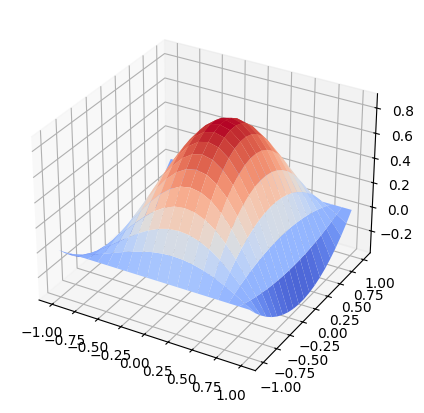

In [23]:
plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, x_plot, cmap=cm.coolwarm)
plt.grid(True)

# plt.figure(figsize=(10, 5))
g = x_train.numpy().flatten()
# grad_x = np.gradient(g, t_train.numpy().flatten())
# print(max(grad_x)/(2 * np.pi))

# ax = plt.plot(t_train, grad_x, 'b')
# plt.grid(True)
# plt.xlabel(r'$t$')
# plt.ylabel(r'$\frac{du}{dt}$')

Sample Rate: 200.0 Hz


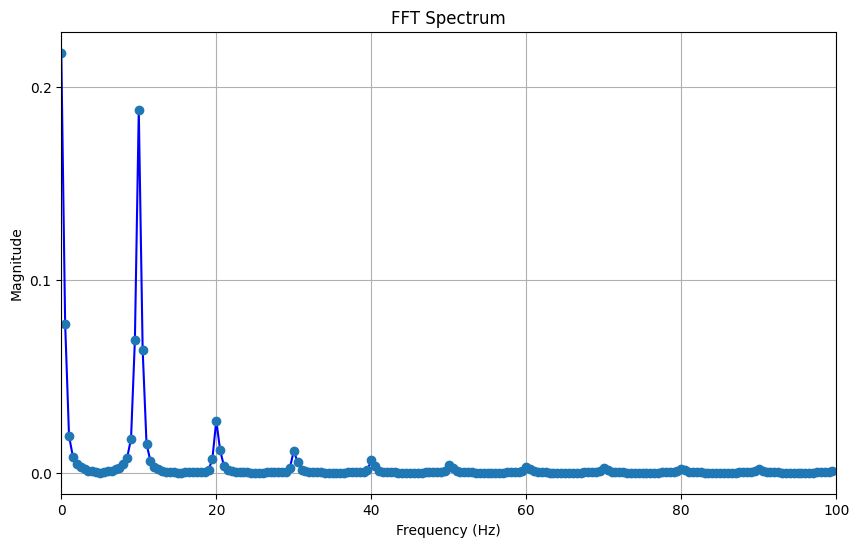

Dominant Frequency: 0.0 Hz
Magnitude: 0.21763761136991494


In [28]:
# Calculate dominant frequency
N = len(g)
# Total time range
total_time_range = 2  # from -1 to 1

# Calculate the sample rate
sample_rate = N / total_time_range
print(f"Sample Rate: {sample_rate} Hz")

# Perform FFT
T = 1.0 / sample_rate
yf = fft(g)
xf = fftfreq(N, T)[:N//2]

# Plot the FFT spectrum
plt.figure(figsize=(10, 6))
plt.plot(xf, np.abs(yf[:N//2]) / N, 'b')
plt.plot(xf, np.abs(yf[:N//2]) / N, 'o')
plt.title("FFT Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim([0, 100])
plt.yticks(np.arange(0, 0.3, 0.1))
plt.grid(True)
plt.show()

# Identify the dominant frequency
dominant_freq_idx = np.argmax(np.abs(yf[:N//2]))
dominant_freq = xf[dominant_freq_idx]
magnitude = np.abs(yf[dominant_freq_idx]) / N

print(f"Dominant Frequency: {dominant_freq} Hz")
print(f"Magnitude: {magnitude}")

In [29]:
'''
Train a neural network to learn the error of stage 1
'''
# acts = 0 indicates selecting tanh as the activation function
layers = [2, 20, 20, 20, 1]
kappa0 =  2 * np.pi * dominant_freq if dominant_freq else 1
model_0 = PhysicsInformedNN(t_train, x_train, layers, kappa0, lt, ut, acts=0)
# start the first stage training
model_0.train(3000, 1)     # mode 1 use Adam
model_0.train(10000, 2)    # mode 2 use L-bfgs
x_pred = model_0.predict(t_eval)

error_x = np.linalg.norm(x_eval-x_pred, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x))

Mode: LBFGS, Iter: 3000, loss: 4.0271e-07
Mode: LBFGS, Iter: 6000, loss: 1.4598e-07
Mode: LBFGS, Iter: 9000, loss: 6.8633e-08
Error u: 5.540065e-04


In [40]:
xmin = x_eval.numpy().min()
xmax = x_eval.numpy().max()

# plt.figure(figsize=(10, 6))
# plt.plot(t_eval, x_eval, 'b-', linewidth = 2, label = 'Exact')
# plt.plot(t_eval, x_pred, 'r--', linewidth = 2, label = 'Prediction')
# plt.ylabel('$u$', fontsize=15, rotation = 0)
# plt.title('Stage 1', fontsize=10)
# plt.xlim([-1.0, 1.0])
# plt.ylim([xmin,xmax])
# plt.legend()

Text(0.5, 0.92, 'Error -- Stage 1')

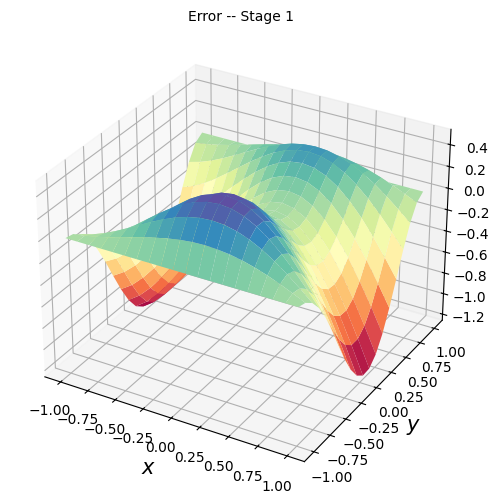

In [43]:
# calculate the error for the first stage
eg_1 = x_train - model_0.predict(t_train)
eg_1_plot = x_plot - model_0.predict(t_train_plot)
eps_1 = np.sqrt(1/t_train.shape[0] * sum([i**2 for i in eg_1]))
eg_1_norm = eg_1 / eps_1
g = eg_1_norm.numpy().flatten()

plt.figure(figsize=(10, 6))
ax = plt.axes(projection="3d")
ax.plot_surface(xx, yy, eg_1_plot, cmap=cm.Spectral)
# plt.plot(t_train, eg_1, 'b', linewidth = 2, label = 'Error')
plt.ylabel('$y$', fontsize=15, rotation = 0)
plt.xlabel('$x$', fontsize=15, rotation = 0)
plt.title('Error -- Stage 1', fontsize=10)

## Stage 2

Sample Rate: 200.0 Hz
Dominant Frequency: 8.5 Hz
Magnitude: 0.278679756057193


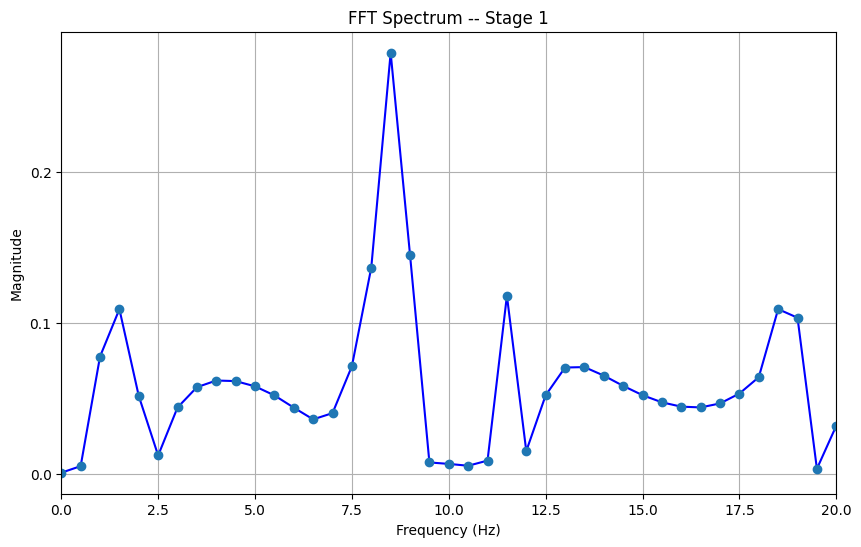

In [31]:
# Calculate dominant frequency of the error from stage 1
N = len(g)
sample_rate = N / total_time_range
print(f"Sample Rate: {sample_rate} Hz")
# Perform FFT
T = 1.0 / sample_rate
yf = fft(g)
xf = fftfreq(N, T)[:N//2]
dominant_freq_idx = np.argmax(np.abs(yf[:N//2]))
dominant_freq = xf[dominant_freq_idx]
magnitude = np.abs(yf[dominant_freq_idx]) / N

print(f"Dominant Frequency: {dominant_freq} Hz")
print(f"Magnitude: {magnitude}")

# Plot the FFT spectrum
plt.figure(figsize=(10, 6))
plt.plot(xf, np.abs(yf[:N//2]) / N, 'b')
plt.plot(xf, np.abs(yf[:N//2]) / N, 'o')
plt.title("FFT Spectrum -- Stage 1")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim([0, 20])
plt.yticks(np.arange(0, 0.3, 0.1))
plt.grid(True)
plt.show()

In [32]:
# Calculate kappa for Stage 2
if dominant_freq < g.size / (6 * np.pi):
    kappa1 = 2 * np.pi * dominant_freq
    print('Kappa 1', kappa1)
else:
    print('Not enough data: Please Increase')

Kappa 1 53.40707511102649


In [33]:
'''
Train Neural Network (the error)
'''
layers = [2, 20, 20, 20, 1]
model_1 = PhysicsInformedNN(t_train, eg_1_norm, layers, kappa1, lt, ut, acts=1)
# start the second stage training
model_1.train(5000, 1)    # mode 1 use Adam
model_1.train(20000, 2)   # mode 2 use L-bfgs
eg_1_pred = model_1.predict(t_eval)
# combining the result from first and second stage
x_p = x_pred + eps_1 * eg_1_pred

error_x = np.linalg.norm(x_eval-x_p, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x))

Mode: LBFGS, Iter: 3000, loss: 1.9073e-03
Mode: LBFGS, Iter: 6000, loss: 4.8664e-07
Mode: LBFGS, Iter: 9000, loss: 6.9214e-11
Mode: LBFGS, Iter: 12000, loss: 5.4187e-15
Mode: LBFGS, Iter: 15000, loss: 3.3253e-19
Error u: 1.272011e-03


In [35]:
# plt.figure(figsize=(10, 6))
# plt.plot(t_eval, x_eval, 'b-', linewidth = 2, label = 'Exact')
# plt.plot(t_eval, x_p, 'r--', linewidth = 2, label = 'Prediction')
# plt.ylabel('$u$', fontsize=15, rotation = 0)
# plt.title('Stage 2', fontsize=10)
# plt.xlim([-1.0, 1.0])
# plt.ylim([xmin,xmax])
# plt.legend()

Text(0.5, 0.92, 'Error -- Stage 2')

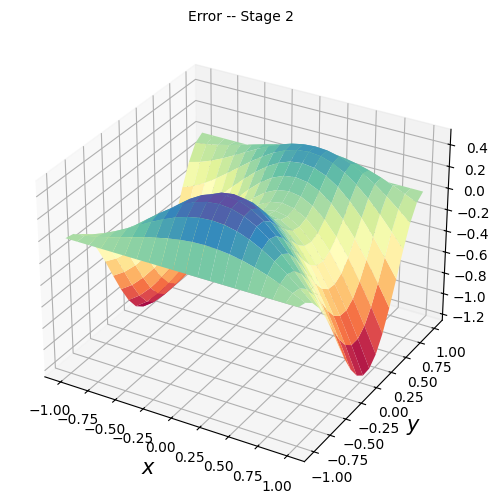

In [46]:
# calculate the residue for the second stage
eg_2 = x_train - model_0.predict(t_train) - eps_1 * model_1.predict(t_train)
eg_2_plot = x_plot - model_0.predict(t_train_plot) - eps_1 * model_1.predict(t_train_plot)
eps_2 = np.sqrt(1/t_train.shape[0] * sum([i**2 for i in eg_2]))
eg_2_norm = eg_2 / eps_2
g = eg_2_norm.numpy().flatten()


plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, eg_2_plot, cmap=cm.Spectral)
# plt.plot(t_train, eg_2, 'b', linewidth = 2, label = 'Error')
plt.xlabel('$x$', fontsize=15, rotation=0)
plt.ylabel('$y$', fontsize=15, rotation = 0)
plt.title('Error -- Stage 2', fontsize=10)

## Stage 3

In [47]:
# Calculate dominant frequency of the error from stage 1
N = len(g)
sample_rate = N / total_time_range
print(f"Sample Rate: {sample_rate} Hz")
# Perform FFT
T = 1.0 / sample_rate
yf = fft(g)
xf = fftfreq(N, T)[:N//2]
dominant_freq_idx = np.argmax(np.abs(yf[:N//2]))
dominant_freq = xf[dominant_freq_idx]
magnitude = np.abs(yf[dominant_freq_idx]) / N

print(f"Dominant Frequency: {dominant_freq} Hz")
print(f"Magnitude: {magnitude}")

Sample Rate: 200.0 Hz
Dominant Frequency: 50.0 Hz
Magnitude: 0.12634856207948025


Increasing data
Sample Rate: 20.0 Hz
Dominant Frequency: 0.5 Hz
Magnitude: 0.6578082584528047


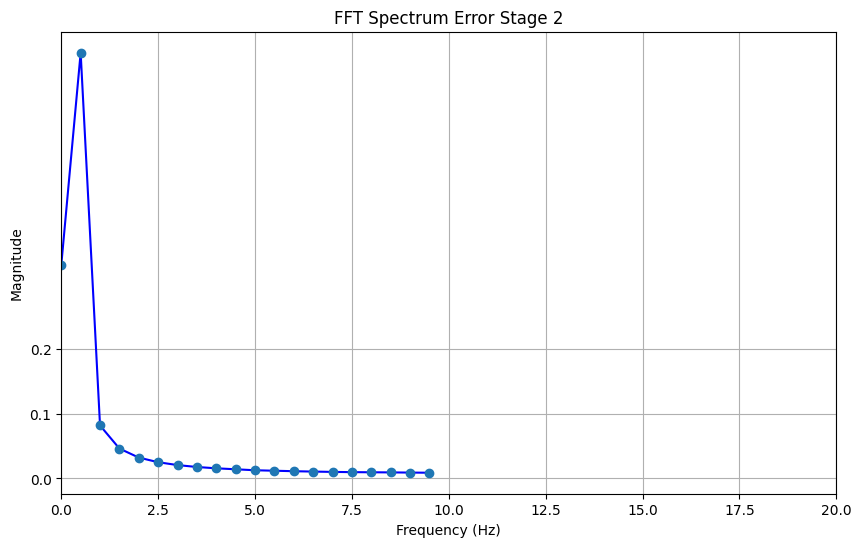

Ntrain new 40
3.141592653589793


In [48]:
'''
Second stage of training
'''
while dominant_freq > g.size / (6 * np.pi):
    print('Increasing data')
    Ntrain = Ntrain  + 20
    t = np.linspace(-1.0, 1.0, Ntrain)[:, None]
    t_train = tf.cast(t, dtype=tf.float64)
    x_train = fun_test(t_train)
    eg_2 = x_train - model_0.predict(t_train) - eps_1 * model_1.predict(t_train)
    eps_2 = np.sqrt(1/t_train.shape[0] * sum([i**2 for i in eg_2]))
    eg_2_norm = eg_2 / eps_2
    g = eg_2_norm.numpy().flatten()
    N = len(g)
    sample_rate = N / total_time_range
    print(f"Sample Rate: {sample_rate} Hz")
    # Perform FFT
    T = 1.0 / sample_rate
    yf = fft(g)
    xf = fftfreq(N, T)[:N//2]
    dominant_freq_idx = np.argmax(np.abs(yf[:N//2]))
    dominant_freq = xf[dominant_freq_idx]
    magnitude = np.abs(yf[dominant_freq_idx]) / N
    
    print(f"Dominant Frequency: {dominant_freq} Hz")
    print(f"Magnitude: {magnitude}")



# Plot the FFT spectrum
plt.figure(figsize=(10, 6))
plt.plot(xf, np.abs(yf[:N//2]) / N, 'b')
plt.plot(xf, np.abs(yf[:N//2]) / N, 'o')
plt.title("FFT Spectrum Error Stage 2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim([0, 20])
plt.yticks(np.arange(0, 0.3, 0.1))
plt.grid(True)
plt.show()


print('Ntrain new', Ntrain)
kappa2 = 2 * np.pi * dominant_freq
print(kappa2)

In [49]:
# (acts = 1 indicates selecting sin as the activation function)
layers = [2, 20, 20, 20, 1]
model_2 = PhysicsInformedNN(t_train, eg_2_norm, layers, kappa2, lt, ut, acts=1)
# start the third stage training
model_2.train(5000, 1)      # mode 1 use Adam
model_2.train(20000, 2)     # mode 2 use L-bfgs
eg_2_pred = model_2.predict(t_eval)
# combining the result from first, second and third stages
x_p = x_pred + eps_1 * eg_1_pred + eps_2 * eg_2_pred

error_x = np.linalg.norm(x_eval-x_p, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x))


Mode: LBFGS, Iter: 3000, loss: 3.4294e-07
Mode: LBFGS, Iter: 6000, loss: 3.2939e-07
Mode: LBFGS, Iter: 9000, loss: 3.1544e-07
Mode: LBFGS, Iter: 12000, loss: 2.8722e-07
Mode: LBFGS, Iter: 15000, loss: 2.7028e-07
Mode: LBFGS, Iter: 18000, loss: 2.5935e-07
Error u: 1.429708e+00


Text(0.5, 0.92, 'Error -- Stage 3')

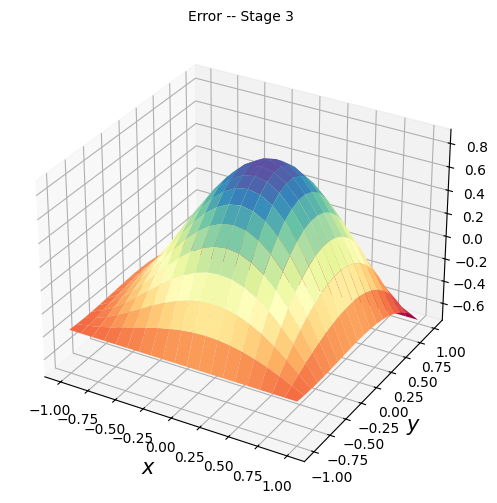

In [50]:
# calculate the residue for the second stage
eg_3 = x_train - model_0.predict(t_train)- eps_1 * model_1.predict(t_train)- eps_2 * model_2.predict(t_train)
eg_3_plot = x_plot - model_0.predict(t_train_plot) - eps_1 * model_1.predict(t_train_plot) - eps_2 * model_2.predict(t_train_plot)
eps_3 = np.sqrt(1/t_train.shape[0] * sum([i**2 for i in eg_3]))
eg_3_norm = eg_3 / eps_3
g = eg_3_norm.numpy().flatten()


plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, eg_3_plot, cmap=cm.Spectral)
# plt.plot(t_train, eg_2, 'b', linewidth = 2, label = 'Error')
plt.xlabel('$x$', fontsize=15, rotation=0)
plt.ylabel('$y$', fontsize=15, rotation = 0)
plt.title('Error -- Stage 3', fontsize=10)

## 3rd stage

In [51]:
N = len(g)
sample_rate = N / total_time_range
print(f"Sample Rate: {sample_rate} Hz")
# Perform FFT
T = 1.0 / sample_rate
yf = fft(g)
xf = fftfreq(N, T)[:N//2]
dominant_freq_idx = np.argmax(np.abs(yf[:N//2]))
dominant_freq = xf[dominant_freq_idx]
magnitude = np.abs(yf[dominant_freq_idx]) / N

print(f"Dominant Frequency: {dominant_freq} Hz")
print(f"Magnitude: {magnitude}")

Sample Rate: 20.0 Hz
Dominant Frequency: 9.5 Hz
Magnitude: 0.44556109896944684


Increasing data
Increasing data
Increasing data
Increasing data
Increasing data
Increasing data
Increasing data
Increasing data
Dominant Frequency: 10.5 Hz
Magnitude: 0.2663708200940714


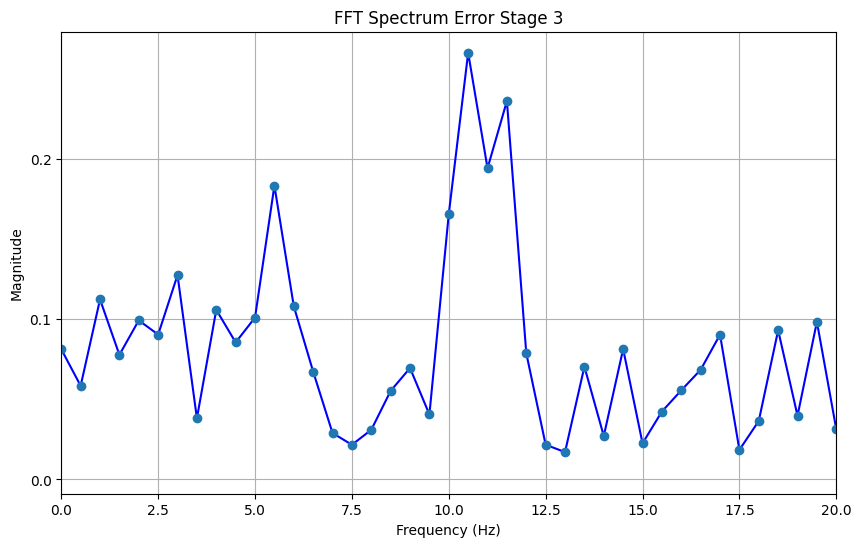

Ntrain new 200
65.97344572538566


In [52]:
'''
Third stage of training
'''
while dominant_freq > g.size / (6 * np.pi):
    print('Increasing data')
    Ntrain = Ntrain  + 20
    t = np.linspace(-1.0, 1.0, Ntrain)[:, None]
    t_train = tf.cast(t, dtype=tf.float64)
    x_train = fun_test(t_train)
    eg_3 = x_train - model_0.predict(t_train) - eps_1 * model_1.predict(t_train)  - eps_2 * model_2.predict(t_train)
    eps_3 = np.sqrt(1/t_train.shape[0] * sum([i**2 for i in eg_3]))
    eg_3_norm = eg_3 / eps_3
    g = eg_3_norm.numpy().flatten()
    N = len(g)
    sample_rate = N / total_time_range
    #print(f"Sample Rate: {sample_rate} Hz")
    # Perform FFT
    T = 1.0 / sample_rate
    yf = fft(g)
    xf = fftfreq(N, T)[:N//2]
    dominant_freq_idx = np.argmax(np.abs(yf[:N//2]))
    dominant_freq = xf[dominant_freq_idx]
    magnitude = np.abs(yf[dominant_freq_idx]) / N
    
print(f"Dominant Frequency: {dominant_freq} Hz")
print(f"Magnitude: {magnitude}")


# Plot the FFT spectrum
plt.figure(figsize=(10, 6))
plt.plot(xf, np.abs(yf[:N//2]) / N, 'b')
plt.plot(xf, np.abs(yf[:N//2]) / N, 'o')
plt.title("FFT Spectrum Error Stage 3")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim([0, 20])
plt.yticks(np.arange(0, 0.3, 0.1))
plt.grid(True)
plt.show()


print('Ntrain new', Ntrain)
kappa3 = 2 * np.pi * dominant_freq
print(kappa3)

In [53]:
# (acts = 1 indicates selecting sin as the activation function)
layers = [2, 30, 30, 30, 30, 1]
model_3 = PhysicsInformedNN(t_train, eg_3_norm, layers, kappa3, lt, ut, acts=1)
# start the third stage training
model_3.train(5000, 1)      # mode 1 use Adam
model_3.train(30000, 2)     # mode 2 use L-bfgs
eg_3_pred = model_3.predict(t_eval)
# combining the result from first, second and third stages
x_p = x_pred + eps_1 * eg_1_pred + eps_2 * eg_2_pred + eps_3 * eg_3_pred

error_x = np.linalg.norm(x_eval-x_p, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x))

Mode: LBFGS, Iter: 3000, loss: 3.8317e-05
Mode: LBFGS, Iter: 6000, loss: 3.2547e-10
Mode: LBFGS, Iter: 9000, loss: 2.5861e-15
Mode: LBFGS, Iter: 12000, loss: 1.2672e-20
Error u: 1.429781e+00


In [54]:
# plt.figure(figsize=(10, 6))
# plt.plot(t_train, eg_3, 'b', linewidth = 2, label = 'Exact')
# plt.plot(t_eval, eg_3_pred * eps_3, 'r-.', linewidth = 2, label = 'Prediction')
# plt.ylabel('$x$', fontsize=15, rotation = 0)
# plt.title('Stage 4', fontsize=10)
# plt.xlim([-1.0, 1.0])
# plt.legend()

In [55]:
# combine the loss of all four stages of training
loss = np.array(model_0.loss + model_1.loss + model_2.loss + model_3.loss)